In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import rgb2hex
import numpy as np
from datetime import timedelta  
import datetime
import seaborn as sns; sns.set()
from itertools import compress
import itertools

import import_ipynb
from utils_common import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.figure_factory as ff # map of the US
import plotly.graph_objects as go
import plotly.express as px
from urllib.request import urlopen
import json

importing Jupyter notebook from utils_common.ipynb


In [2]:
# https://github.com/descarteslabs/DL-COVID-19/blob/master/DL-us-m50.csv
_DLAB_DATA_FILE_ = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50.csv'
# https://github.com/descarteslabs/DL-COVID-19/blob/master/DL-us-m50_index.csv
_DLAB_I_DATA_FILE_ = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-m50_index.csv'

In [3]:
_Figure_PATH_ = './figures_US/figures_us_be/'
_State_PATH_ = './data_US/data_NYT_state.csv'
_County_PATH_ = './data_US/data_NYT_county.csv'

In [4]:
def load_DLAB_raw():
    '''
    This provides a way to lookinto the 'raw' data
    '''
    raw = pd.read_csv(_DLAB_DATA_FILE_)
    raw = raw.melt(id_vars =['country_code', 'admin_level', 'admin1', 'admin2', 'fips'])  
    rename_dict = {'variable': 'update_date',
                   'country_code': 'country_name',
                   'admin_level': 'admin_level',
                   'admin1': 'state_name',
                   'admin2': 'county_name',
                   'fips': 'fips',
                   'value': 'value',
                  }
    raw = raw.rename(columns=rename_dict)
    raw['update_date'] = pd.to_datetime(raw['update_date'])  # original type of update_time after read_csv is 'str'
    raw['update_date'] = raw['update_date'].dt.date
    new_col = ['update_date', 'country_name', 'state_name', 'county_name', 'fips', 'value']
    raw = raw[new_col]
    data = raw.reset_index(drop=True)
    raw = pd.read_csv(_DLAB_I_DATA_FILE_)
    raw = raw.melt(id_vars =['country_code', 'admin_level', 'admin1', 'admin2', 'fips'])  
    rename_dict = {'variable': 'update_date',
                   'country_code': 'country_name',
                   'admin_level': 'admin_level',
                   'admin1': 'state_name',
                   'admin2': 'county_name',
                   'fips': 'fips',
                   'value': 'ratio',
                  }
    raw = raw.rename(columns=rename_dict)
    raw['update_date'] = pd.to_datetime(raw['update_date'])  # original type of update_time after read_csv is 'str'
    raw['update_date'] = raw['update_date'].dt.date
    new_col = ['update_date', 'country_name', 'state_name', 'county_name', 'fips', 'ratio']
    raw = raw[new_col]
    data = pd.merge(data, raw, on=['update_date', 'country_name', 'state_name', 'county_name', 'fips'])
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    data_state = data[data['county_name'].isnull()]
    data_state = data_state.drop(['county_name'], axis = 1)
    # rename D.C.
    data_state.at[data_state.index[data_state['state_name'] == 'Washington, D.C.'].tolist(), 'state_name'] = 'Washington'
    data_county = data[data['county_name'].notnull()]
    data_county['county_name'] = data_county.apply(lambda row: row.county_name.partition(' ')[0], axis = 1)
    
    data_county.at[data_county.index[(data_county['county_name'] == 'New') & (data_county['state_name'] == 'New York')].tolist(), 'county_name'] = 'New York City'
    
    return data_state, data_county

def load_NYT_raw():
    raw_state = pd.read_csv(_State_PATH_) 
    raw_state['update_date'] = pd.to_datetime(raw_state['update_date'])
    raw_state['update_date'] = raw_state['update_date'].dt.date
    raw_county = pd.read_csv(_County_PATH_) 
    raw_county['update_date'] = pd.to_datetime(raw_county['update_date'])
    raw_county['update_date'] = raw_county['update_date'].dt.date
    raw_county.at[raw_county.index[raw_county['county_name'] == 'Kansas City'].tolist(), 'fips'] = 293800
    raw_county.at[raw_county.index[raw_county['county_name'] == 'New York City'].tolist(), 'fips'] = 36061
    raw_county = raw_county[(raw_county['county_name']!='Unknown')].copy()
    return raw_state, raw_county

In [5]:
data_m_state, data_m_county = load_DLAB_raw()

Data date range:  2020-03-01 to 2020-05-14
Number of rows in raw data:  201428


In [6]:
# State level map as html file
def figure_map_html(df, update_date_tr, col, title = None, country = 'US', cmap = 'Tealrose'):
    df = df.copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    names_state_sub = data_single['state_name'].tolist()
    names_state_sub.sort()
    locations = [names_state_short_dict[name] for name in names_state_sub]
    values = [round(data_single[data_single['state_name'] == item][col].tolist()[0], 4) for item in names_state_sub]
    colorbar_dict = {'value': 'value', 'ratio': 'ratio'}
    fig = go.Figure(data = go.Choropleth(
        locations = locations, # Spatial coordinates
        z = values, # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = cmap,
        marker_line_color = 'white',
        colorbar_title = colorbar_dict[col],
        colorbar = dict(
        thickness = 15,
        len = 0.8,
        yanchor = "top", 
        x = 0.95,
        y = 0.9,),
        hoverinfo = 'location+text',
        text = values,
    ))
    title_dict = {'value': 'Mobility (unit: km)', 'ratio': 'Mobility index (unit: %)'}
    fig.update_layout(
        title_text = title + '  ' + update_date_tr.strftime("%d %B, %Y") + 
        '<br>' + title_dict[col],  
        title = dict(x = 0.5, y = 0.85),
        width = 450, 
        height = 300,
        font = dict(
        size = 10,),
        margin = dict(l = 10, r = 10, t = 50, b = 10),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor='rgb(255, 255, 255)'),
    )
    name_dict = {'value': 'mobility', 'ratio': 'mobility_index'}
    fig.write_html(_Figure_PATH_ + country + '_' + name_dict[col] + '.html')
    return fig

In [7]:
# State level map as html file
def figure_map_png(df, update_date_tr, col, title = None, country = 'US', cmap = 'Tealrose'):
    df = df.copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    names_state_sub = data_single['state_name'].tolist()
    names_state_sub.sort()
    locations = [names_state_short_dict[name] for name in names_state_sub]
    values = [round(data_single[data_single['state_name'] == item][col].tolist()[0], 4) for item in names_state_sub]
    colorbar_dict = {'value': 'value', 'ratio': 'ratio'}
    fig = go.Figure(data = go.Choropleth(
        locations = locations, # Spatial coordinates
        z = values, # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = cmap,
        marker_line_color = 'white',
        colorbar_title = colorbar_dict[col],
        colorbar = dict(
        thickness = 15,
        len = 0.8,
        yanchor = "top", 
        x = 0.95,
        y = 0.9,),
        hoverinfo = 'location+text',
        text = values,
    ))
    title_dict = {'value': 'Mobility (unit: km)', 'ratio': 'Mobility index (unit: %)'}
    fig.update_layout(
        title_text = title + '  ' + update_date_tr.strftime("%d %B, %Y") + 
        '<br>' + title_dict[col],  
        title = dict(x = 0.5, y = 0.95),
        width = 1800, 
        height = 1050,
        font = dict(
        size = 30,),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor='rgb(255, 255, 255)'),
    )
    name_dict = {'value': 'mobility', 'ratio': 'mobility_index'}
    fig.write_image(_Figure_PATH_ + country + '_' + name_dict[col] + '.png')
    return fig

In [8]:
date_tr = max(data_m_state['update_date'])
# 'earth', 'fall', 'geyser', 'mint', 'teal', 
fig = figure_map_html(data_m_state, date_tr, 'value', title = 'United States', country = 'US', cmap =  'geyser')
fig = figure_map_html(data_m_state, date_tr, 'ratio', title = 'United States', country = 'US', cmap =  'geyser')

In [9]:
fig = figure_map_png(data_m_state, date_tr, 'value', title = 'United States', country = 'US', cmap =  'geyser')
fig = figure_map_png(data_m_state, date_tr, 'ratio', title = 'United States', country = 'US', cmap =  'geyser')

In [10]:
# County level map
def figure_map_state_html(df, update_date_tr, col, title = None, country = 'US', cmap = 'geyser'):
    
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)
    
    df = df.copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    # deal with fips
    data_single['fips'] = data_single['fips'].astype('str')
    data_single['fips'] = data_single['fips'].apply(lambda x: x[:-2]).apply(lambda x: x.zfill(5)) # remove '.0' and add '0' in the front
    # remove rows with nonexisting fips
    data_single = data_single[data_single['fips'].isin([item['id'] for item in counties['features']])]
    # rounding
    data_single['value'] = data_single['value'].apply(lambda x: round(x, 4))
    # add missing counties
    for item in counties['features']:
        if item['id'] not in data_single['fips'].tolist():
            new_row = {'update_date': update_date_tr, 
                       'country_name': 'US',
                       'state_name': item['properties']['STATE'], 'county_name': item['properties']['NAME'], 
                       'fips': item['id'], 
                       'value': np.nan, 'ratio': np.nan}
            data_single = data_single.append(new_row, ignore_index = True)
    data_single[col + '_log'] = data_single[col].apply(lambda x: np.log10(x))
    fig = px.choropleth(data_single, geojson = counties, locations = 'fips', color = col + '_log',
                        color_continuous_scale = cmap, 
                        hover_name = 'county_name',
                        hover_data = {'state_name': True, col: True, col + '_log': False},
                        scope = "usa",
                       )
    fig.layout.template = None
    title_dict = {'value': 'Mobility (unit: km)', 'ratio': 'Mobility index (unit: %)'}
    colorbar_dict = {'value': 'value', 'ratio': 'ratio'}
    fig.update_layout(
        title_text = title + '  ' + update_date_tr.strftime("%d %B, %Y") + 
        '<br>' + title_dict[col],
        title = dict(x = 0.5, y = 0.85),
        width = 450, 
        height = 300,
        font = dict(
        size = 10,),
        coloraxis_colorbar = dict(
            title = colorbar_dict[col],
            tickvals = [-1, 0, 1, 2, 3],
            ticktext = ['0.1', '1', '10', '100', '1000'],
            thickness = 15,
            len = 0.8,
            yanchor = "top", 
            x = 0.95,
            y = 0.9,
            outlinecolor = 'white'),
        margin = dict(l = 0, r = 10, t = 30, b = 10), 
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor = 'rgb(255, 255, 255)'),
    )
    #print("plotly express hovertemplate:", fig.data[0].hovertemplate)
    fig.update_traces(hovertemplate = '<b>%{hovertext}, %{customdata[0]}</b><br>' + col + ': %{customdata[1]}<extra></extra>')
    fig.update_traces(marker = dict(line = dict(width = 0.1, color = 'black')),)
    name_dict = {'value': 'mobility', 'ratio': 'mobility_index'}
    fig.write_html(_Figure_PATH_ + country + '_state_' + name_dict[col] + '.html')

In [11]:
# County level map
def figure_map_state_png(df, update_date_tr, col, title = None, country = 'US', cmap = 'geyser'):
    
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)
    
    df = df.copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    # deal with fips
    data_single['fips'] = data_single['fips'].astype('str')
    data_single['fips'] = data_single['fips'].apply(lambda x: x[:-2]).apply(lambda x: x.zfill(5)) # remove '.0' and add '0' in the front
    # remove rows with nonexisting fips
    data_single = data_single[data_single['fips'].isin([item['id'] for item in counties['features']])]
    # rounding
    data_single['value'] = data_single['value'].apply(lambda x: round(x, 4))
    # add missing counties
    for item in counties['features']:
        if item['id'] not in data_single['fips'].tolist():
            new_row = {'update_date': update_date_tr, 
                       'country_name': 'US',
                       'state_name': item['properties']['STATE'], 'county_name': item['properties']['NAME'], 
                       'fips': item['id'], 
                       'value': np.nan, 'ratio': np.nan}
            data_single = data_single.append(new_row, ignore_index = True)
    data_single[col + '_log'] = data_single[col].apply(lambda x: np.log10(x))
    fig = px.choropleth(data_single, geojson = counties, locations = 'fips', color = col + '_log',
                        color_continuous_scale = cmap, 
                        hover_name = 'county_name',
                        hover_data = {'state_name': True, col: True, col + '_log': False},
                        scope = "usa",
                       )
    fig.layout.template = None
    title_dict = {'value': 'Mobility (unit: km)', 'ratio': 'Mobility index (unit: %)'}
    colorbar_dict = {'value': 'value', 'ratio': 'ratio'}
    
    fig.update_layout(
        title_text = title + '  ' + update_date_tr.strftime("%d %B, %Y") + 
        '<br>' + title_dict[col],
        width = 1800, 
        height = 1050,
        font = dict(
        size = 30,),
        coloraxis_colorbar = dict(
            title = colorbar_dict[col],
            tickvals = [-1, 0, 1, 2, 3],
            ticktext = ['0.1', '1', '10', '100', '1000'],
            thickness = 40,
            len = 0.8,
            yanchor = "top", 
            y = 0.9,
            outlinecolor = 'white'),
        margin = dict(l = 5, r = 20, t = 25, b = 20),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor = 'rgb(255, 255, 255)'),
    )
    #print("plotly express hovertemplate:", fig.data[0].hovertemplate)
    fig.update_traces(hovertemplate = '<b>%{hovertext}, %{customdata[0]}</b><br>' + col + ': %{customdata[1]}<extra></extra>')
    fig.update_traces(marker = dict(line = dict(width = 0.1, color = 'black')),)
    name_dict = {'value': 'mobility', 'ratio': 'mobility_index'}
    fig.write_image(_Figure_PATH_ + country + '_state_' + name_dict[col] + '.png')

In [12]:
date_tr = max(data_m_county['update_date'])
figure_map_state_html(data_m_county, date_tr, col = 'value', title = 'United States', country = 'US', cmap = 'geyser')
figure_map_state_html(data_m_county, date_tr, col = 'ratio', title = 'United States', country = 'US', cmap = 'geyser')

In [13]:
figure_map_state_png(data_m_county, date_tr, col = 'value', title = 'United States', country = 'US', cmap = 'geyser')
figure_map_state_png(data_m_county, date_tr, col = 'ratio', title = 'United States', country = 'US', cmap = 'geyser')

In [14]:
data_state, data_county = load_NYT_raw()

In [15]:
def figure_mobility_all(df, names_state, fsize = (5,3), ncol = 4, ms = 2, fs = 10, logy = False, 
                    title = None, country = 'US', pvi = False):
    
    sns.set_style("ticks")
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    
    m = len(names_state)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, state in enumerate(names_state):
        
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette[i]
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df[df['state_name'] == state]
        
        axes[ix].plot(plot_df['update_date'], plot_df['value'],
                linewidth = 2, marker = 'o', ms = ms, color = c, label = 'mobility') # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Mobility (unit: km)', fontsize = fs - 2)
        if i == 0:
            axes[ix].legend(loc='upper left', fancybox=True, fontsize = fs - 4)
        
    
        axes[ix].set_title(state, fontsize = fs)
        
    for i, state in enumerate(names_state):   
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette[i]
        ix = np.unravel_index(i, axes.shape)
        plot_df = df[df['state_name'] == state]
        ax11 = axes[ix].twinx()
        
        ax11.grid(False) # hide grid lines
        ax11.plot(plot_df['update_date'], plot_df['ratio'], 
                  linewidth = 2, ms = ms, color = c, label = 'mobility index')
        if i == 0:
            ax11.legend(loc='upper right', fancybox=True, fontsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
        if i % ncol == ncol - 1:
            ax11.set_ylabel('Mobility Index', fontsize = fs - 2)
        
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.WeekdayLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.align_ylabels(axes[:, 0])
    fig.suptitle(title, fontsize = fs + 4, y = 0.94)
    
    if pvi == True:
        
        ix = np.unravel_index(int(ncol/2), axes.shape)
        palette_D = plt.get_cmap('Blues')
        palette_R = plt.get_cmap('Reds')
        palette_Even = plt.get_cmap('Greens')
        palette_None = plt.get_cmap('Purples')
        patch_D = mpatches.Patch(color = palette_D(0.6), label = 'Democratic')
        patch_R = mpatches.Patch(color = palette_R(0.6), label = 'Republican')
        patch_Even = mpatches.Patch(color = palette_Even(0.6), label = 'Even')
        patch_None = mpatches.Patch(color = palette_None(0.6), label = 'None')

        axes[ix].legend(handles = [patch_D, patch_R, patch_Even], loc = 'upper left', 
                   ncol = 4, bbox_to_anchor=(-0.65, 1.55), fontsize = fs, fancybox=True)
    

    #fig.savefig(_Figure_PATH_ + country + '_mobility.png', dpi = 400, bbox_inches='tight')

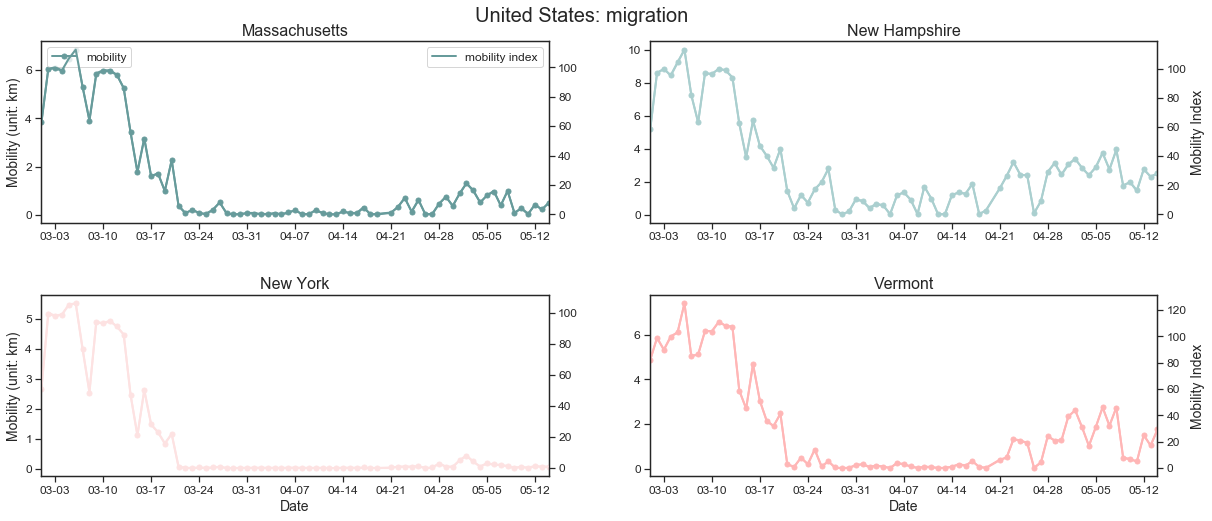

In [16]:
names_state_selected = ['Massachusetts', 'New Hampshire', 'New York', 'Vermont']
figure_mobility_all(data_m_state, names_state_selected, ncol = 2, fsize = (10, 4), ms = 5, fs = 16, logy = False, 
                    title = 'United States: migration', country = 'US', pvi = False)

In [17]:
def figure_mobility_together(df, names_state, fsize = (5,3), ms = 2, fs = 10, logy = False, 
                    title = None, country = 'US', pvi = False):
    
    m = len(names_state)
    sns.set_style("ticks")
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    m = len(names_state)

    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)

    for i, state in enumerate(names_state):

        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette[i]

        
        plot_df = df[df['state_name'] == state]
        ax.plot(plot_df['update_date'], plot_df['value'],
                linewidth = 2, marker = 'o', ms = ms, color = c, label = state) 
    
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Mobility (unit: km)', fontsize = fs - 2)
        
    fig.suptitle(title, fontsize = fs + 4, y = 0.94)
    
    ax.legend(loc='upper center', fancybox=True, ncol = 4, fontsize = fs - 4)
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
    fig.savefig(_Figure_PATH_ + country + '_mobility.png', dpi = 400, bbox_inches='tight')
    

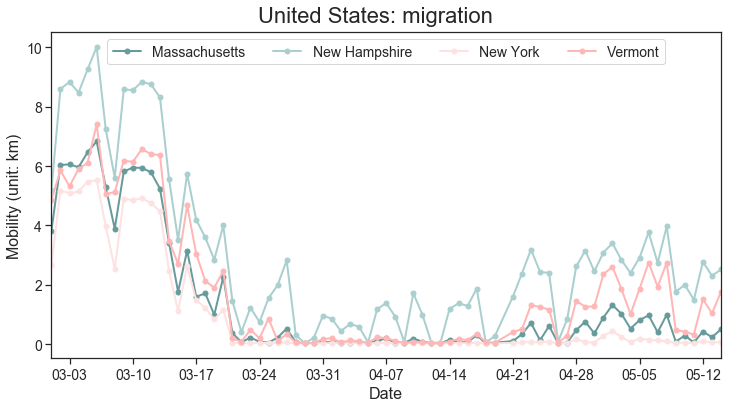

In [18]:
#names_state_selected = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']
figure_mobility_together(data_m_state, names_state_selected, fsize = (12, 6), ms = 5, fs = 18, logy = False, 
                    title = 'United States: migration', country = 'US', pvi = False)

In [19]:
def figure_mobility_state_all(df, df_m, names_state, fsize = (5,3), ncol = 4, ms = 2, fs = 10, logy = False, 
                    title = None, country = 'US'):
    
    sns.set_style("ticks")
    palette = ['#72aaa1', '#b1c7b3', '#f1eac8', '#e5b9ad', '#d98994', '#d0587e'] # tealrose (1-6)
    #palette = ['#009392', '#72aaa1', '#b1c7b3', '#e5b9ad', '#d98994', '#d0587e'] # tealrose (0-2, 4-6)
    
    m = len(names_state)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    
    palette.reverse()
    
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, state in enumerate(names_state):
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df_m[df_m['state_name'] == state]
        
        data_single = df[(df['state_name'] == state) & (df['update_date'] == max(df['update_date']))]
        fips_selected = data_single.sort_values(by = 'cum_confirmed')['fips'].tail(6).tolist()                                                       
        fips_selected.reverse()
        for j, fips in enumerate(fips_selected):
            
            c = palette[j]
            plot_df_single = plot_df[plot_df['fips'] == fips]
            axes[ix].plot(plot_df_single['update_date'], plot_df_single['value'],
                    linewidth = 3, marker = 'o', ms = ms, color = c, alpha = 0.8, label = plot_df_single['county_name'].tolist()[0]) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Mobility (unit: km)', fontsize = fs - 2)
        
        handles, labels = axes[ix].get_legend_handles_labels()
        def flip(items, ncol):
            return itertools.chain(*[items[i::ncol] for i in range(ncol)])
        
        axes[ix].legend(flip(handles, 3), flip(labels, 3), loc='upper center', ncol = 3, fancybox=True, fontsize = fs - 4)
        
    
        axes[ix].set_title(state, fontsize = fs)
        axes[ix].set_xlim(min(df_m.update_date), max(df_m.update_date))
        axes[ix].xaxis.set_major_locator(mdates.DayLocator((1,15)))
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.align_ylabels(axes[:, 0])
    fig.suptitle(title, fontsize = fs + 4, y = 0.94)

    fig.savefig(_Figure_PATH_ + country + '_county_mobility.png', dpi = 400, bbox_inches='tight')

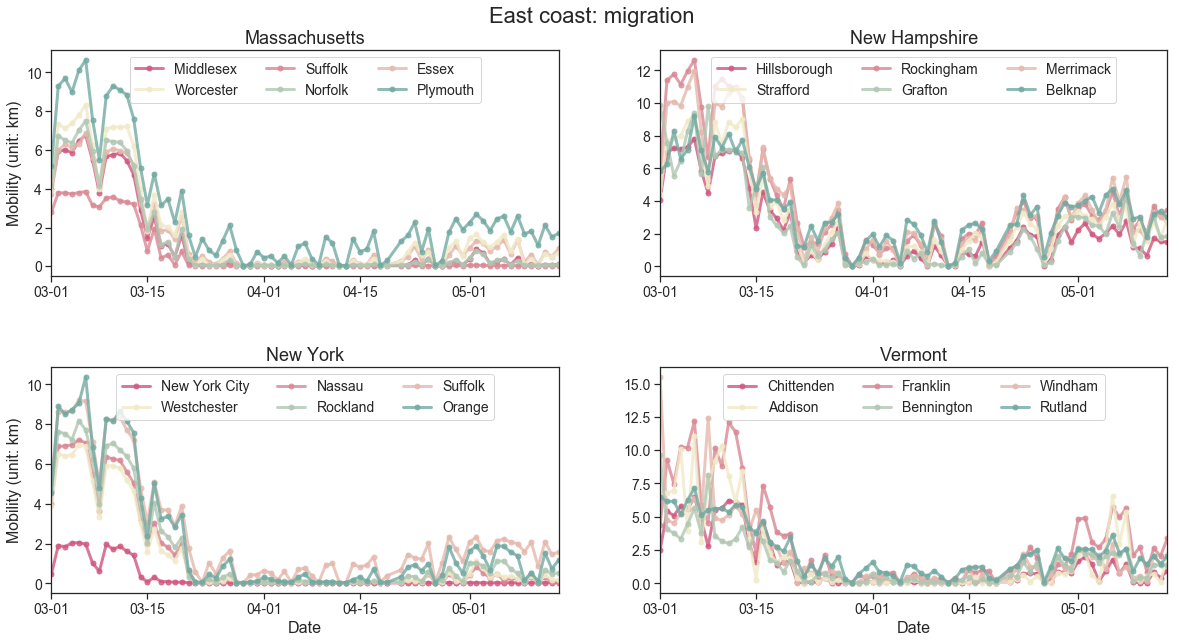

In [20]:
figure_mobility_state_all(data_county, data_m_county, names_state_selected, 
                          fsize = (10,5), ncol = 2, ms = 5, fs = 18, logy = False, 
                    title = 'East coast: migration', country = 'US')
                                                         
                                                         

In [21]:
data_m_nation = data_m_state.groupby(['update_date'])['ratio'].apply(lambda x : x.sum()).reset_index()

In [22]:
def figure_SP(df, df_SP, update_date_initial, fsize = (12,5), ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    df_SP = df_SP[df_SP['update_date'] >= update_date_initial]
    df_SP = df_SP.reset_index(drop = True)
    df_nation = df.groupby(['update_date'])['ratio'].apply(lambda x : x.sum()).reset_index()
    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)
    sns.set_style('ticks')
    ax.plot(df_nation['update_date'], df_nation['ratio'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'Mobility')
    
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Index', fontsize = fs - 2)
    
    ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
    ax_twin = ax.twinx()
    ax_twin.plot(df_SP['update_date'], df_SP['close'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[3], label = 'S&P 500')
    
    ax_twin.set_ylabel('Index', fontsize = fs - 2)
    
    ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor=(1, 1), fancybox=True)
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle('Correlation: mobility and the S & P 500 index', fontsize = fs + 2, y = 0.95)
    
    fig.savefig(_Figure_PATH_ + country + '_mcorrelation.png', dpi = 400, bbox_inches='tight')

Data date range:  1927-12-30 to 2020-05-15
Number of rows in raw data:  23203


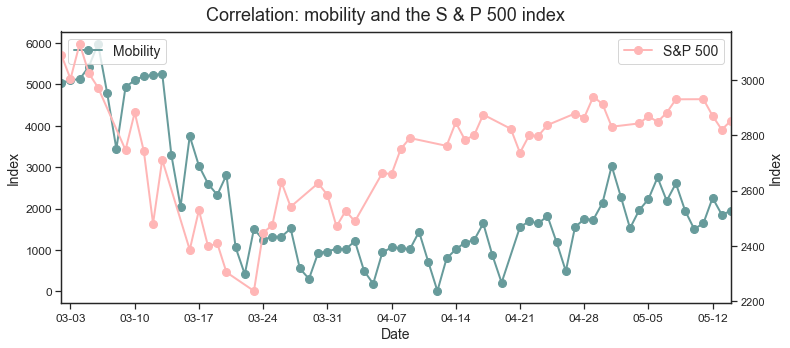

In [23]:
data_SP = load_SP_raw()
date_initial = datetime.date(int(2020),int(3),int(2))
figure_SP(data_m_state, data_SP, date_initial, fsize = (12,5), ms = 8, fs = 16, title = 'United State', country = 'US')

In [24]:
def figure_stock_list(df, stock_name_list, title_name_list, update_date_initial, 
                      fsize = (12,5), ncol = 2, ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    
    df_nation = df.groupby(['update_date'])['ratio'].apply(lambda x : x.sum()).reset_index()
    
    m = len(stock_name_list)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, stock_name in enumerate(stock_name_list):
        
        ix = np.unravel_index(i, axes.shape)
        ax = axes[ix]
        ax.plot(df_nation['update_date'], df_nation['ratio'], 
                linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'Mobility')
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            ax.set_xlabel('Date', fontsize = fs - 2)
        if i % ncol == 0:
            ax.set_ylabel('Index', fontsize = fs - 2)
        
        ax.set_title(title_name_list[i], fontsize = fs)
        
        ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
        ax_twin = ax.twinx()
    
        data_stock = load_STOCK_raw(stock_name)
        data_stock = data_stock[data_stock['update_date'] >= update_date_initial]
        data_stock = data_stock.reset_index(drop = True)
        ax_twin.plot(data_stock['update_date'], data_stock['close'], 
                     linewidth = 2, marker = 'o', ms = ms, color = palette[i%3 + 1], label = stock_name_list[i])
        
        if i % ncol == ncol - 1:
            ax_twin.set_ylabel('Price', fontsize = fs - 2)
    
        ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor=(1, 1), fancybox=True)
    
        ax.set_xlim(min(df.update_date), max(df.update_date))
        ax.xaxis.set_major_locator(mdates.DayLocator((1,15)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle('Correlation: mobility and the stock market', fontsize = fs + 2, y = 0.9)
    
    fig.savefig(_Figure_PATH_ + country + '_mcorrelation_sm.png', dpi = 400, bbox_inches='tight')

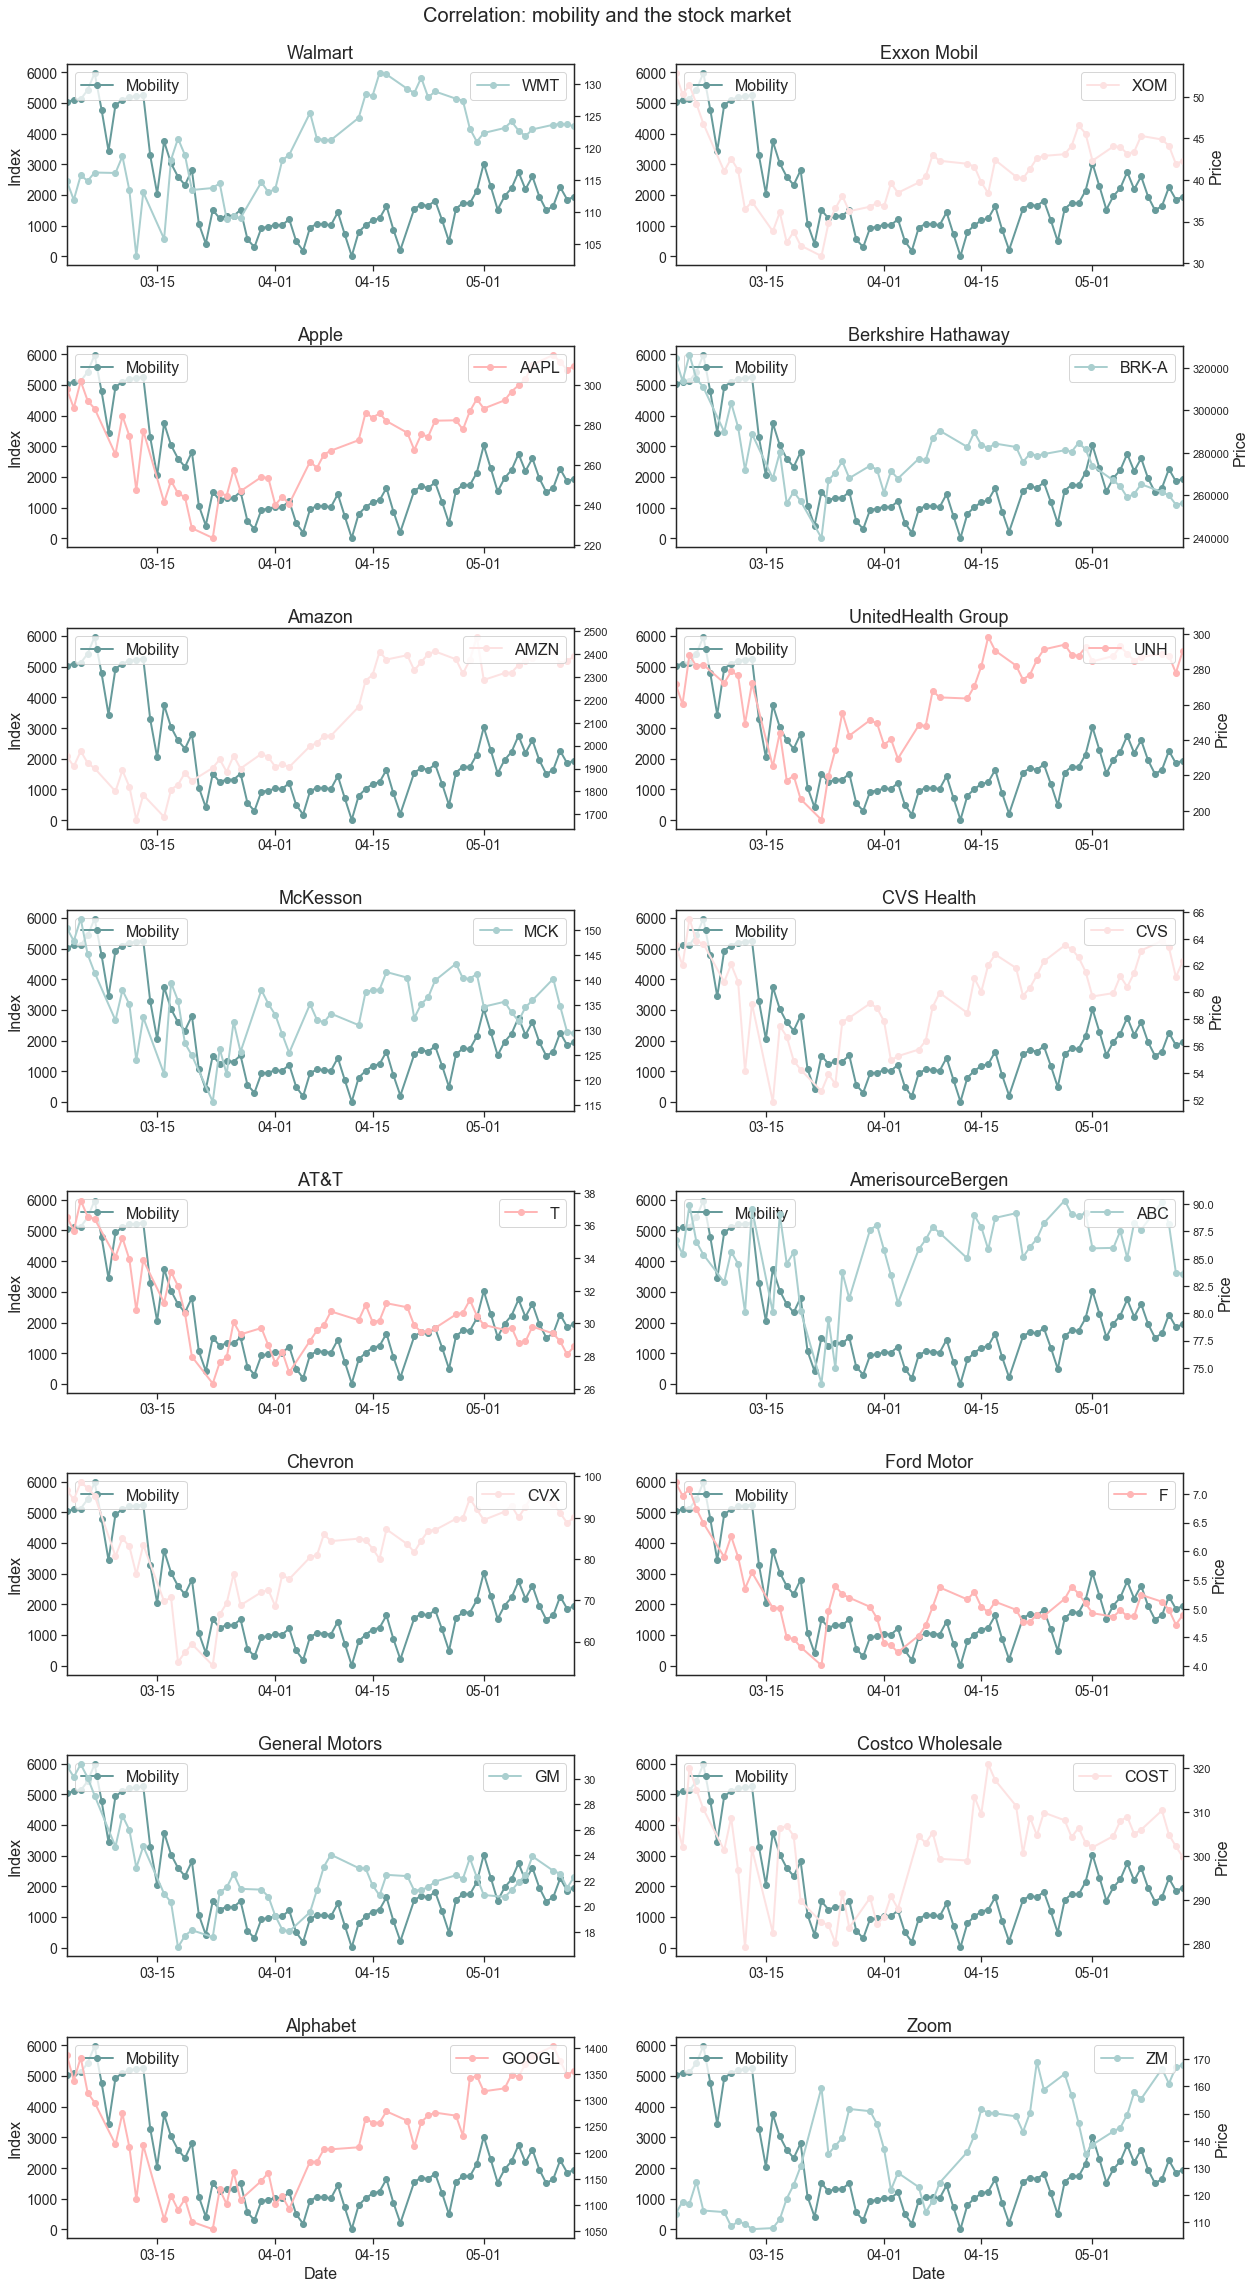

In [25]:
stock_name_list = ['WMT', 'XOM', 'AAPL', 'BRK-A', 'AMZN', 'UNH', 'MCK', 'CVS',
                  'T', 'ABC', 'CVX', 'F', 'GM', 'COST', 'GOOGL', 'ZM']
title_name_list = ['Walmart', 'Exxon Mobil', 'Apple', 'Berkshire Hathaway',
                   'Amazon', 'UnitedHealth Group', 'McKesson', 'CVS Health',
                   'AT&T', 'AmerisourceBergen', 'Chevron', 'Ford Motor', 
                   'General Motors', 'Costco Wholesale', 'Alphabet', 'Zoom']
date_initial = datetime.date(int(2020),int(3),int(2))
figure_stock_list(data_m_state, stock_name_list, title_name_list, 
                  date_initial, fsize = (10,5), ncol = 2, ms = 6, fs = 18,
                  title = 'United States', country = 'US')